In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

ENTROPY_THRESHOLD = 0.69  # Вопросы с значением > 0.69 считаем сложными

train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15


df = pd.read_csv("entropy_mistral.tsv", sep="\t")

# Разбиваем датасет по сложности
df_difficult = df[df["field_entropy_value_mistral"] > ENTROPY_THRESHOLD]
df_easy    = df[df["field_entropy_value_mistral"] <= ENTROPY_THRESHOLD]

print(f"Всего вопросов: {len(df)}")
print(f"Сложных вопросов: {len(df_difficult)}")
print(f"Лёгких вопросов: {len(df_easy)}")


train_d, temp_d = train_test_split(
    df_difficult,
    test_size=(val_ratio + test_ratio),
    random_state=42
)
val_d, test_d = train_test_split(
    temp_d,
    test_size=test_ratio / (val_ratio + test_ratio),
    random_state=42
)

train_e, temp_e = train_test_split(
    df_easy,
    test_size=(val_ratio + test_ratio),
    random_state=42
)
val_e, test_e = train_test_split(
    temp_e,
    test_size=test_ratio / (val_ratio + test_ratio),
    random_state=42
)

print("\nРазбиение по сложности:")
print(f"Сложные: Train = {len(train_d)}, Val = {len(val_d)}, Test = {len(test_d)}")
print(f"Лёгкие:  Train = {len(train_e)}, Val = {len(val_e)}, Test = {len(test_e)}")


Всего вопросов: 11407
Сложных вопросов: 430
Лёгких вопросов: 10977

Разбиение по сложности:
Сложные: Train = 301, Val = 64, Test = 65
Лёгкие:  Train = 7683, Val = 1647, Test = 1647


In [ ]:

# Эксперимент A:
#   Обучение/валидация – только сложные вопросы
#   Тест – тестовая выборка из лёгких вопросов
expA_train = train_d
expA_val   = val_d
expA_test  = test_e  

# Эксперимент B:
#   Обучение/валидация – только лёгкие вопросы
#   Тест – тестовая выборка из сложных вопросов
expB_train = train_e
expB_val   = val_e
expB_test  = test_d  

# включает и сложные, и лёгкие вопросы.
test_combined = pd.concat([test_d, test_e]).sample(frac=1, random_state=42)


expA_train.to_csv("expA_train.tsv", sep="\t", index=False)
expA_val.to_csv("expA_val.tsv", sep="\t", index=False)
expA_test.to_csv("expA_test.tsv", sep="\t", index=False)

expB_train.to_csv("expB_train.tsv", sep="\t", index=False)
expB_val.to_csv("expB_val.tsv", sep="\t", index=False)
expB_test.to_csv("expB_test.tsv", sep="\t", index=False)

test_combined.to_csv("test_combined.tsv", sep="\t", index=False)



Тестовый датасет: 2282 примеров сохранён в 'test.tsv'.
Всего обучающих+валидационных примеров: 9125
Формирование окон: размер окна = 2073 примеров, шаг = 1762 примеров, число окон = 5
Окно 1: индексы [0:2073], примеров: 2073, диапазон энтропии: 0.341 – 2.249
Окно 2: индексы [1762:3835], примеров: 2073, диапазон энтропии: 0.274 – 0.359
Окно 3: индексы [3524:5597], примеров: 2073, диапазон энтропии: 0.222 – 0.284
Окно 4: индексы [5286:7359], примеров: 2073, диапазон энтропии: 0.172 – 0.230
Окно 5: индексы [7048:9121], примеров: 2073, диапазон энтропии: 0.015 – 0.181
Окно 1: сохранено 1658 примеров в train и 415 примеров в valid (файлы: 'window1_train.tsv', 'window1_valid.tsv').
Окно 2: сохранено 1658 примеров в train и 415 примеров в valid (файлы: 'window2_train.tsv', 'window2_valid.tsv').
Окно 3: сохранено 1658 примеров в train и 415 примеров в valid (файлы: 'window3_train.tsv', 'window3_valid.tsv').
Окно 4: сохранено 1658 примеров в train и 415 примеров в valid (файлы: 'window4_train.t

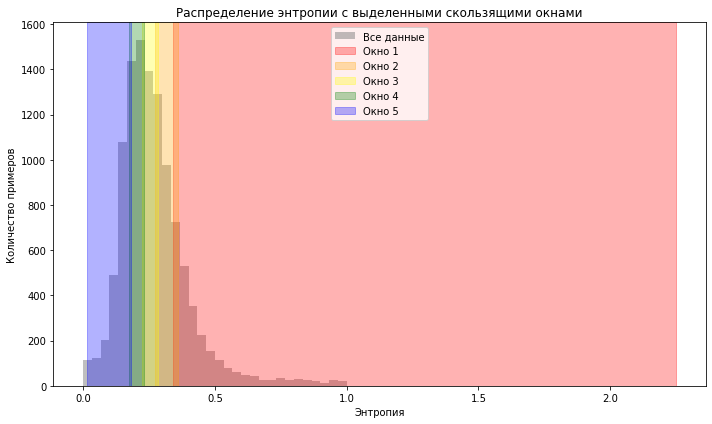

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


df = pd.read_csv("entropy_mistral.tsv", sep="\t")


train_valid_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
test_df.to_csv("test.tsv", sep="\t", index=False)
print(f"Тестовый датасет: {len(test_df)} примеров сохранён в 'test.tsv'.")

train_valid_df = train_valid_df.sort_values(by="field_entropy_value_mistral", ascending=False).reset_index(drop=True)
N = len(train_valid_df)
print(f"Всего обучающих+валидационных примеров: {N}")


desired_n_windows = 5      # желаемое количество окон
overlap_rate = 0.15        # процент перекрытия (можно изменить на 0.15 для 15% перекрытия)
min_examples = 500         # минимум 500 примеров в каждом окне


candidate_window_size = int(N / (1 + (desired_n_windows - 1) * (1 - overlap_rate)))

if candidate_window_size < min_examples:

    window_size = min_examples
    step = int(window_size * (1 - overlap_rate))
    n_windows = 1 + (N - window_size) // step
    print(f"В обучающей выборке недостаточно примеров для {desired_n_windows} окон с минимум {min_examples} примеров. Будет сформировано {n_windows} окон.")
else:
    window_size = candidate_window_size
    n_windows = desired_n_windows
    step = int(window_size * (1 - overlap_rate))

if step < 1:
    step = 1

print(f"Формирование окон: размер окна = {window_size} примеров, шаг = {step} примеров, число окон = {n_windows}")


windows = {}
boundaries = []  

for i in range(n_windows):
    start_idx = i * step
    end_idx = start_idx + window_size
    if end_idx > N:
        end_idx = N  
    window_data = train_valid_df.iloc[start_idx:end_idx].copy()
    
    if len(window_data) < min_examples:
        print(f"Окно {i+1} содержит меньше {min_examples} примеров ({len(window_data)} примеров). Пропускаем его.")
        continue
    
    windows[i+1] = window_data

    max_ent = window_data["field_entropy_value_mistral"].iloc[0]
    min_ent = window_data["field_entropy_value_mistral"].iloc[-1]
    boundaries.append((min_ent, max_ent))
    print(f"Окно {i+1}: индексы [{start_idx}:{end_idx}], примеров: {len(window_data)}, диапазон энтропии: {min_ent:.3f} – {max_ent:.3f}")

for window_id, data in windows.items():
    train_window, valid_window = train_test_split(data, test_size=0.2, random_state=42)
    train_filename = f"window{window_id}_train.tsv"
    valid_filename = f"window{window_id}_valid.tsv"
    train_window.to_csv(train_filename, sep="\t", index=False)
    valid_window.to_csv(valid_filename, sep="\t", index=False)
    print(f"Окно {window_id}: сохранено {len(train_window)} примеров в train и {len(valid_window)} примеров в valid (файлы: '{train_filename}', '{valid_filename}').")

plt.figure(figsize=(10, 6))
bins = np.linspace(0, 1, 31)  
plt.hist(df["field_entropy_value_mistral"], bins=bins, color="gray", alpha=0.5, label="Все данные")

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'cyan']


for idx, (min_ent, max_ent) in enumerate(boundaries):
    plt.axvspan(min_ent, max_ent, color=colors[idx % len(colors)], alpha=0.3, label=f"Окно {idx+1}")

plt.xlabel("Энтропия")
plt.ylabel("Количество примеров")
plt.title("Распределение энтропии с выделенными скользящими окнами")
plt.legend()
plt.tight_layout()
plt.savefig("entropy_sliding_windows_histogram.png")
plt.show()
